ver 6.0 
Supervised contrastive

# Enviroment setup

In [1]:
!pip install tensorflow-addons
# !pip install recommenders
!pip install "dask[dataframe]" --upgrade
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 9.6 MB/s 
     |████████████████████████████████| 4.9 MB 10.0 MB/s 
     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 48.3 MB 1.6 MB/s 
     |████████████████████████████████| 99 kB 9.4 MB/s 
     |████████████████████████████████| 92 kB 13.0 MB/s 
     |████████████████████████████████| 237 kB 73.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 62.5 MB/s 
     |████████████████████████████████| 352 kB 73.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.2 MB/s 


# Libs

In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc
import math
import datetime, time

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow_addons.losses import TripletSemiHardLoss 

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

from tqdm import tqdm
import dask.dataframe as dd
from joblib import Parallel, delayed

# from recommenders.datasets.python_splitters import python_random_split
# from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
# from recommenders.models.cornac.cornac_utils import predict_ranking

In [3]:
tf.__version__

'2.8.2'

# Data

## Movies

In [4]:
itemCol = 'movieId'
userCol = 'userId'

In [6]:
# DGX setup
# fpath = "./ml-20m"

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Mounted at /content/gdrive


In [7]:
# Loading movie
movies = pd.read_csv(fpath+'/movies.csv')
movies["year"]=movies["title"].apply(lambda x: x.strip()[-5:-1] if x.strip()[-5:-1][0:2] in ('18', '19', '20') else -1)
movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
movies["title"]= movies.apply(lambda x: x["title"][0:-7] if x["year"] != -1 else x["title"], axis=1)
movies["year_norm"] = movies["year"].astype('int').apply(lambda x: -1 if x==-1 else (x-1891)/(2015-1891))
movies.head()

,movieId,title,genres,year,year_norm
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,0.83871
1,2,Jumanji,Adventure Children Fantasy,1995,0.83871
2,3,Grumpier Old Men,Comedy Romance,1995,0.83871
3,4,Waiting to Exhale,Comedy Drama Romance,1995,0.83871
4,5,Father of the Bride Part II,Comedy,1995,0.83871


In [8]:
# vect = CountVectorizer()
# genre_vect = vect.fit_transform(movies["genres"]).todense()
# genre_vect= np.array(genre_vect)
# movies["genres_vect"] = [genre_vect[i] for i in range(genre_vect.shape[0])]

## BERT

In [9]:
# tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
# tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
# title_prep = bert_preprocess_model(
#      movies['title']
#     )

In [11]:
# title_vect = bert_model( title_prep )['pooled_output']

## Ratings

In [12]:
# user-wise train-test split
def user_wise_split(userCol, test_size=0.25):
    df = pd.read_csv(fpath+'/ratings.csv')
    df["y"] = df["rating"]/2.5-1
    all_user = df[userCol].drop_duplicates()
    train_user, test_user = train_test_split(all_user, test_size=test_size)

    train_ratings = df[df[userCol].isin(train_user)]
    test_ratings = df[df[userCol].isin(test_user)]
    return train_ratings, test_ratings

train, test= user_wise_split(userCol,test_size= 0.35)

In [13]:
top_k_item = 20000
wu_size = 200
max_item = wu_size

top_items = train.groupby(itemCol).count().sort_values(by=userCol, ascending=False).head(top_k_item).index

# Class  model

In [14]:
class TimeTrachker():
    """Tracking runing time"""
    def start(self):
        self.start_time = time.time()

    def check(self, des = ''):
        try:
            if self.check_time is None:
                self.check_time = self.start_time
        except:
            self.check_time = self.start_time
        self.end_time = time.time()
        dur = self.end_time - self.check_time
        print(des + " duration: ", dur)

        self.check_time = time.time()
        return dur

    def stop(self, des = ''):
        self.end_time = time.time()
        dur = self.end_time - self.start_time
        print(des + " duration: ", dur)
        self.start_time = time.time()
        self.check_time = None
        return dur

timer = TimeTrachker()

In [15]:
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = interaction.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

In [16]:
# Building model
class Efficient_Rec(tf.keras.Model):
    def __init__(self, encoder, wu_size= 200, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.encoder = encoder
        self.wu_size = wu_size

    # from v2.2: chỉ groupby, không padding
    @staticmethod
    def get_interaction_set(interaction, max_item = None, top_k_item = None):
        """
        Input:
            interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
            max_item: int: item num limit
        Output:
            df, itemCol: list, y: list, itemCol_str: string, userCol as index
            list item sắp xếp theo giảm dần độ lớn rating
        """
        items = interaction.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
        if top_k_item is not None:
            top_items = items.head(top_k_item).index
            interaction = interaction[interaction[itemCol].isin(top_items)]
        else:
            top_items = items.index

        # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
        rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
        interaction = interaction.reindex(rindex)
        
        # Chuyển thành warm-up set theo từng user
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

        # Giới hạn độ dài warm_up size
        if max_item is not None:
            interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
            interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

        return interaction, top_items

    @staticmethod
    def padding_list(list_item, wu_size, value=0, is_padding=True):
        series_item1 = list_item[0:wu_size]
        if is_padding:
            series_item1 = series_item1+[value]*(wu_size-len(series_item1))
        return series_item1


    def _preprocess(self, inputs, padding_size = 100):
        """
        Padding về wu_size và mask_size, convert list of items => string of items
        batch_inputs: df: itemStr, y"""

        items_list, ratings_list = inputs

        items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
        ratings =   np.stack( ratings_list.apply(lambda x: self.padding_list( x, padding_size  ) ) )

        return items, ratings

    def preprocessing_full_ft(self, inputs, padding_size = 100):
        items_list, genres_list, years_list, ratings_list = inputs

        items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
        ratings =   np.stack( ratings_list.apply(lambda x: self.padding_list( x, padding_size  ) ) )
        genres = genres_list
        years =  np.stack( years_list.apply(lambda x: self.padding_list( x, padding_size  ) ) )

        return items,genres,years, ratings


    @staticmethod
    def get_top_cluster(scores, interaction_list, cluster_num=5):
        interaction_list_ = interaction_list.copy()
        idx = np.argsort(-scores.transpose(),axis=0)[:cluster_num]
        interaction_list_["clusters"] = [list(i) for i in idx.transpose()]
        interaction_list_["scores"] = [ list(scores[i][ind]) for i, ind in enumerate(idx.transpose()) ]
        return interaction_list_

    def minibatch_clustering(self, interaction_list, batch_size= 512):
        chunks = [interaction_list[i:i+batch_size] for i in range(0,interaction_list.shape[0],batch_size)]
        preds = []
        for chunk in chunks:
            if using_full_feature:
                pred = self.encoder(
                            self.preprocessing_full_ft( [chunk[itemCol], chunk["genres"], chunk["year_norm"], chunk["y"]], 
                                                        padding_size = wu_size )
                            ).numpy()
            else:
                pred = self.encoder(self._preprocess( [chunk[itemCol], chunk["y"]], padding_size = wu_size )).numpy()

            preds.append( pred )

        return np.concatenate(preds)

    @staticmethod
    def chunk_explode(ratings, batch_size = 1024**2):
        chunks = [ratings[i:i+batch_size] for i in range(0,ratings.shape[0],batch_size)]
        explodes = []

        # Todo: convert for loop to parallel
        def chunk_process(chunk):
            explode = chunk.explode(["clusters", "scores"])
            explode["contribute_score"] = explode["scores"].astype("float64")*explode["y"]
            explode = explode.groupby(["clusters", "movieId"]).agg({
                "contribute_score": ["mean", "count"]
            }).reset_index()
            explode.columns = ["clusters", "movieId", "mean", "count"]

            return explode

        explodes = Parallel(n_jobs = -1, verbose = 1)(
                    delayed(chunk_process)(chunk) for chunk in tqdm(chunks))
        # combine results
        gr = pd.concat(explodes, axis = 0)
        gr["product"] = gr["mean"]*gr["count"]
        gr = gr.groupby(["clusters", "movieId"]).sum().reset_index()
        gr["contribute_score"] = gr["product"]/gr["count"]
        gr = gr[["clusters", "movieId", "contribute_score"]]
        return gr

    def get_shortlist(self, ratings, interaction_list= None, limit = 500, cluster_num = 5, batch_size=512):
        timer.start()
        if interaction_list is None:
            interaction_list_, _ = self.get_interaction_set(  ratings, max_item = max_item, top_k_item = top_k_item  )
        else:
            interaction_list_ = interaction_list.copy()

        scores = self.minibatch_clustering(interaction_list_, batch_size=batch_size)

        # Limit number of cluster for each user
        interaction_list_ = self.get_top_cluster(scores, interaction_list_, cluster_num= cluster_num)
        timer.check(des = "Get cluster")

        # Get shortlist for each cluster
        ratings_ = ratings.copy().set_index("userId")
        ratings_ = ratings_[ratings_["y"]>0]
        ratings_ = ratings_.join(interaction_list_, rsuffix="_l", how = "inner")
        timer.check(des = "Join interaction")
        ratings_ = self.chunk_explode(ratings_, batch_size= 1024*200)
        timer.check(des = "Chunk explode")

        ratings_["rank"] = ratings_.groupby("clusters")["contribute_score"].rank(method='first', ascending=False)
        ratings_ = ratings_[(ratings_["rank"] <= limit)&(ratings_["contribute_score"]>0)]
        timer.check(des = "Chunk explode")

        self.shortlist = ratings_

        timer.stop(des = "Total")

    @staticmethod
    def left_anti_user_item_join( left, right ):
        """Fast left anijoin 2 dataframe by one column"""
        wu_key = left[userCol].astype('str')+"&"+left[itemCol].astype('str')
        blacklist = right[userCol].astype('str')+"&"+right[itemCol].astype('str')

        key_diff = set(wu_key).difference(blacklist)
        where_diff = wu_key.isin(key_diff)
        output = left[where_diff]

        return output


    def batch_get_recommend(self, warm_up= None, historical_ratings = None, top_k = 10, is_remove_interacted = True, 
        batch_size=1024, reduce_method="random", using_rapids= False, cluster_num= 5):
        """
        reduce_method: str, 'random' or 'mean'
        """
        print("historical_ratings shape ", historical_ratings.shape)
        timer.start()
        if warm_up is None:
            if using_full_feature:
                warm_up, _ = get_interaction_itemft_set( 
                     historical_ratings, movies
                    , max_item = max_item
                    , top_k_item = top_k_item )
            else:
                warm_up, _ = get_interaction_set( 
                         historical_ratings
                        , max_item = max_item
                        , top_k_item = top_k_item )

        scores = self.minibatch_clustering(warm_up, batch_size=512)
        wu = self.get_top_cluster( scores, warm_up, cluster_num= cluster_num)

        wu = wu.explode(["clusters", "scores"]).reset_index()[[userCol, "clusters", "scores"]]
        timer.check(des = "Get cluster for user")
        print("wu shape ", wu.shape)
        
        user_num = wu[userCol].drop_duplicates().shape[0]
        print("user_num ", user_num)

        # cudf.from_pandas
        if using_rapids:
            wu = dd.from_pandas(wu)
            historical_ratings = dd.from_pandas(historical_ratings.copy())

        chunks = [wu[wu[userCol].isin(range(i,i+batch_size))] 
                  for i in range(0,user_num,batch_size)]

        his_chunks = [historical_ratings[historical_ratings[userCol].isin(range(i,i+batch_size))] 
                        for i in range(0,user_num,batch_size)]
       
        shortlist = self.shortlist

        def batch_join_process(chunk, his_chunk):
            timer2 = TimeTrachker()
            timer2.start()

            wu = chunk.merge(shortlist, on="clusters", how='inner')
            print('''wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape: ''', wu.shape)
            wu["matched_score"] = wu["scores"]*wu["contribute_score"]

            if reduce_method=="mean":
                wu = wu.groupby([userCol, itemCol]).agg({"matched_score":'mean'}).reset_index()
            
            if reduce_method=="random":
                # using drop_duplicates for boost speed, may reduce accuracy.
                wu = wu.drop_duplicates(subset=["userId", "movieId"])

            print('''after reduce wu shape: ''', wu.shape)
            timer2.check(des = "reduce")

            if is_remove_interacted:
                wu = self.left_anti_user_item_join( wu, historical_ratings )

            print('''after remove interacted wu shape: ''', wu.shape)
            timer2.check(des = "remove interacted item")

            wu["rank"] = wu.groupby(userCol)["matched_score"].rank(method='first', ascending=False)
            wu = wu[wu["rank"]<= top_k]

            timer2.stop(des = "all chunk processing time")

            return wu 
        
        timer.check(des = "Prepare to join")
        wus = Parallel(n_jobs = -1, backend= 'threading', verbose = 1)(
                    delayed(batch_join_process)(chunk, his_chunk) for chunk, his_chunk in tqdm(zip(chunks, his_chunks)))
        
        gc.collect()

        timer.check(des = "Join")

        output = pd.concat(wus, axis=0)

        timer.stop(des = "Total")
        return output

    def release_cache(self):
        self.interaction_list = None 
        gc.collect()

# Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [17]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 821 ms, sys: 407 ms, total: 1.23 s
Wall time: 4.52 s


In [18]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs
        deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(y, axis=1), tf.float32), -1)
        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y, deno

In [19]:
# Xây dựng mạng
embedding_size = 173
reps_size = 132
preference_vector_size = 43

@tf.function
def avg_layer(z):
    t = K.sum(z[0], axis=1)/z[1]
    t = tf.clip_by_value( t, -1, 1 )
    t = tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    return t


def interaction_embedding():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di1')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di2')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di3')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)

    uprofile = layers.Dense( reps_size, activation='relu', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du4')(uprofile)
    uprofile = layers.Dense(preference_vector_size, activation='sigmoid', name='clustering')(uprofile)
    
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [20]:
# # Example of layer interaction embedding step by step
# input_wi = ["15 25 65 20 84",  # 5 items
#             "51 54 45 21 24 83 81 76 74 75 72 48 29 38",# 14 items
#             " ", # 0 item
#             ] 

# tvectorizer = layers.TextVectorization( max_tokens= 17, split='whitespace', output_sequence_length= 10)
# tvectorizer.adapt( input_wi ) 

# wi = tvectorizer(input_wi)
# print("afer TextVectorization layer \n",wi)
# wi = layers.Embedding(input_dim= 17, output_dim= 4, mask_zero= True, name='ei')(wi)
# print("afer Embedding layer \n",wi)
# wi = layers.Dense(3, activation='sigmoid',  use_bias = False, name='di')(wi)

# wr = np.array([[0.5, 0.1, -0.5, 1, 0.25, 0, 0, 0, 0, 0], [0.25, 0.15, 0.5, 1, 0.25, 0.5, 0.1, -0.9, 0.4, -0.3], [0,0,0,0,0,0,0,0,0,0]])

# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print("afer Multiply layer \n",ireps)
# uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)
# print("afer Average layer \n",uprofile)

# uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
# uprofile = layers.LayerNormalization(name='norm')(uprofile)
# uprofile = layers.Dense(5, activation='sigmoid', name='clustering')(uprofile)
# print("afer Sigmoid layer \n",uprofile)

In [21]:
# Kiểm tra tham số
# interaction_embedding().summary()

In [22]:
# tf.keras.utils.plot_model( interaction_embedding() ,show_shapes=True, show_dtype=True, show_layer_names=True )

## Full feature encoder

In [23]:
def get_interaction_itemft_set(interaction, movies, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = interaction.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
        movies = movies[movies[itemCol].isin(top_items)]
    else:
        top_items = items.index

    interaction = interaction.merge(movies, on=[itemCol], how='left' )

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list, "genres": list, "year_norm": list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

In [24]:
genre_dims = 5
max_genre_num = 20

genre_vectorizer = layers.TextVectorization( max_tokens= 20, split='whitespace', output_sequence_length= wu_size, name = 'gvectorizer')
genre_vectorizer.adapt( movies["genres"] ) 

In [44]:
def user_embedding():

    # Warmup itemId
    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di1')(wi)
    wi = layers.Dense(embedding_size, activation='linear', use_bias = False, name='di2')(wi) # (batch_size, wu_size, embedding_size)

    # Warmup genre
    input_wg = layers.Input(shape=(1,), name='input_wg')
    wg = genre_vectorizer(input_wg)
    wg = layers.Embedding(input_dim= max_genre_num, output_dim= genre_dims, mask_zero= True, name='eg')(wi)
    wg = layers.Lambda(lambda x: K.mean(x, axis=-1))(wg)
    wg = layers.Dense(genre_dims, activation='relu', use_bias = False, name='dg1')(wg)
    wg = layers.Dense(genre_dims, activation='linear', use_bias = False, name='dg2')(wg) # (batch_size, wu_size, genre_dims)

    # Warmup year of movie
    input_wy = layers.Input(shape=(wu_size,), name='input_wy')
    wy = layers.Lambda(lambda x: K.expand_dims(x, axis=-1))(input_wy)

    # Full features
    wf = layers.Concatenate(axis=-1)([wi, wg, wy])
    wf = layers.Dense( reps_size, activation='relu', name='wf1')(wf)
    wf = layers.Dense( reps_size, activation='linear', name='wf2')(wf)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wf, wr])
    uprofile = layers.Lambda( avg_layer )(ireps) # (batch_size, wu_size)

    uprofile = layers.Dense( reps_size, activation='relu', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    uprofile = layers.Dense(preference_vector_size, activation='sigmoid', name='clustering')(uprofile)
    
    
    model = tf.keras.Model(inputs= [input_wi, input_wg, input_wy, wr], outputs=[uprofile])
    return model

# Evaluate model results

In [45]:
def model_evaluate(model, movies, df, is_full_ft = False ):
    if not is_full_ft:
        dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
        group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()
    else:
        dfu, ttop_items = get_interaction_itemft_set( 
                     df, movies
                    , max_item = max_item
                    , top_k_item = top_k_item )
        group_scores = model.encoder(model.preprocessing_full_ft( [dfu[itemCol], dfu["genres"], dfu["year_norm"], dfu["y"]], padding_size = wu_size )).numpy()

    print("SAMPLE INTERACTION EMBEDDING")
    print( np.max(group_scores), np.mean(group_scores), np.min(group_scores) )
    print( group_scores[0:3] )

    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    
    print("CLUSTER CHECKING")
    check_cluster(group_scores)
    
    print("SPECTROGRAM PLOT")
    plot_spectrogram(group_scores)

def get_label(movies, df, is_encode = False):
    movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
    movie_genres = movies.explode("genres_list")
    gr = df.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
    gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

    labels = gr[gr["rank"] ==1].set_index("userId")
    # labels["pred_max_ind"] = np.argmax(group_scores, axis=1)

    if is_encode:
        label_enc = LabelEncoder()
        labels["label"] = label_enc.fit_transform(labels["genres_list"])

    return labels

def feature_plot( movies, df, group_scores ):
    tlabels = get_label(movies, df)

    tsne = PCA(n_components=2, random_state=123)
    # tsne = TSNE(n_components=2, random_state=123)
    z = tsne.fit_transform(group_scores) 

    df = pd.DataFrame()
    df["y"] = tlabels["genres_list"]
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    plt.rcParams["figure.figsize"] = (8,8)
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette="Paired" ,#sns.color_palette("hls", 3),
                    data=df)#.set(title="Iris data T-SNE projection") 
    plt.show()

def check_cluster(group_scores):
    # Kiểm tra số user trong mỗi cụm có bị vón cục
    ugs= np.argmax(group_scores, axis=1)
    for i in range(50):
        print(i,': ', np.sum(ugs==i) )

def plot_spectrogram(group_scores):
    # Sort theo user_group + draw sigmoid/softmax layer
    plt.rcParams["figure.figsize"] = (10,10)
    k =100
    a = group_scores
    ind = np.argmax(group_scores, axis=1)
    plt.imshow( a[np.argsort(ind)][0:k] )
    plt.show()


In [46]:
def model_plot(model, movies, df, is_full_ft = False):
    if not is_full_ft:
        dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
        group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()
    else:
        dfu, ttop_items = get_interaction_itemft_set( 
                     df, movies
                    , max_item = max_item
                    , top_k_item = top_k_item )
        group_scores = model.encoder(model.preprocessing_full_ft( [dfu[itemCol], dfu["genres"], dfu["year_norm"], dfu["y"]], padding_size = wu_size )).numpy()
    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    

# Warm start user

In [47]:
%%time
u_train_from = 0
u_train_to = u_train_from + 130000
u_test = u_train_to + 5000

using_full_feature = True

def get_labeled_data(df):
    if using_full_feature:
        interact_df, _ = get_interaction_itemft_set( 
                     df, movies
                    , max_item = max_item
                    , top_k_item = top_k_item )
    else:
        interact_df, _ = get_interaction_set( 
                     df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    labels = get_label( movies, df, is_encode = True)
    interact_df["label"] = labels["label"]
    return interact_df#[["movieId","y","label"]]
try:
    train_warm
except:
    # if exists, do not rerun
    train_warm =  get_labeled_data( train[(train[userCol]>u_train_from)&(train[userCol]<u_train_to)] )
    train_warm["rating_num"] = train_warm.apply(lambda x: len(x["y"]), axis=1)
    # pretrain with warm start user
    train_warm = train_warm[train_warm["rating_num"]>=100]

print( train_warm.shape )

(32149, 6)
CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 1.2 ms


In [48]:
gc.collect()

4933

In [49]:
# x = train[["userId", "rating"]].groupby("userId").count()
# x["rating_num_clip"] = x["rating"].clip(0, 700).apply(lambda x: int(x/20)*20)
# x.groupby("rating_num_clip").count().plot()

In [50]:
# x.groupby("rating_num_clip").count()

In [51]:
gc.collect()

150

# supervised constrastive 

In [52]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [53]:
# Thực hiện training
def _supervised_constrastive_train_step(self, inputs):
    items_pd, ratings_pd, labels = inputs["movieId"], inputs["y"], inputs["label"]
    items, ratings = self._preprocess((items_pd, ratings_pd), wu_size)

    with tf.GradientTape() as tape:
        # Interaction embedding
        vec = self.encoder([items, ratings])

        average_loss = self.loss(labels, vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    
    # Gradient clipping
    # gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
    #              for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._supervised_constrastive_train_step = _supervised_constrastive_train_step

In [54]:
# Thực hiện minibatch training
def _spv_constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._supervised_constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
        gc.collect()
    return np.mean(losses)

Efficient_Rec._spv_constrastive_train_minibatch_step = _spv_constrastive_train_minibatch_step

In [55]:
# Compile model
model = Efficient_Rec( encoder = interaction_embedding(), 
                      wu_size = wu_size,
                      use_tf_function=False)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.001),
    loss= TripletSemiHardLoss() # SupervisedContrastiveLoss(temperature = 0.05),
)

In [80]:
# Load trained model
# latest = tf.train.latest_checkpoint("/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/")
# model.encoder.load_weights(latest)
# test_set = train[(train[userCol]>15000)&(train[userCol]<20000)]
# model_plot(model, movies, test_set )

In [57]:
%%time
# Train new model
# epochs= 6
# test_set = train[(train[userCol]>15000)&(train[userCol]<20000)]
# model_plot(model, movies, test_set )
# for n in range(epochs):
#   print(n, "/", epochs, ": ", model._spv_constrastive_train_minibatch_step(train_warm.sample(frac=1.), batch_size=512))
#   model_plot(model, movies, test_set )
#   gc.collect()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [58]:
# model.encoder.save_weights("/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/encoder_v6",save_format='tf')

In [59]:
# model_evaluate(model, movies, 
#                warm_up_mask[(warm_up_mask[userCol]>u_train_to)&(warm_up_mask[userCol]<=u_test)])

## Full feature supervised contrastive

In [60]:
# Thực hiện training
def _supervised_constrastive_fullft_train_step(self, inputs):
    items_pd, ratings_pd, genres_pd, years_pd, labels = inputs["movieId"], inputs["y"], inputs["genres"], inputs["year_norm"], inputs["label"]
    items,genres,years, ratings = self.preprocessing_full_ft((items_pd, genres_pd, years_pd, ratings_pd), wu_size)

    # genres = genres_pd
    # years = np.stack( years_pd.apply(lambda x: self.padding_list( x, wu_size ) ) )

    with tf.GradientTape() as tape:
        # Interaction embedding
        vec = self.encoder([items, genres, years, ratings])

        average_loss = self.loss(labels, vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    
    # Gradient clipping
    # gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
    #              for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._supervised_constrastive_fullft_train_step = _supervised_constrastive_fullft_train_step

In [61]:
# Thực hiện minibatch training
def _spv_constrastive_train_minibatch_step_fullft(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._supervised_constrastive_fullft_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
        gc.collect()
    return np.mean(losses)

Efficient_Rec._spv_constrastive_train_minibatch_step_fullft = _spv_constrastive_train_minibatch_step_fullft

In [62]:
# Compile model
model = Efficient_Rec( encoder = user_embedding(), 
                      wu_size = wu_size,
                      use_tf_function=False)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.001),
    loss= TripletSemiHardLoss() # SupervisedContrastiveLoss(temperature = 0.05),
)

FEATURE PLOT


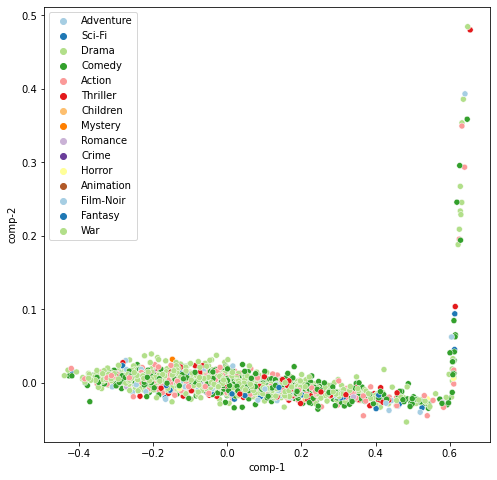

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.99786705>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9968522>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9956394>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9974853>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9969845>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.99821067>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.99475205>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.99604464>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.99698204>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9960502>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9954385>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9884017>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9937813>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9979183>}
{'batch_loss': 

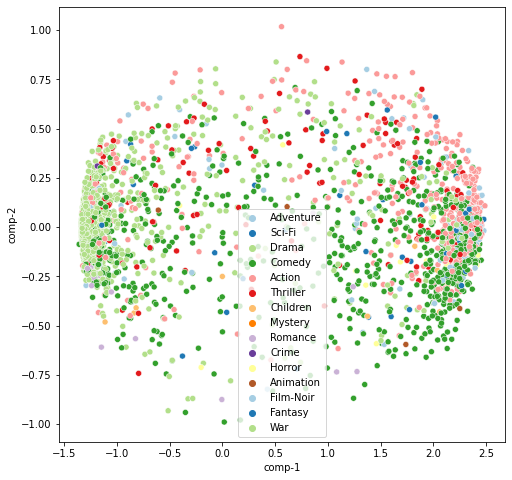

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9857239>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.978044>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.98265904>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.98656654>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9866156>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.98472184>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9751923>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.96774805>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.95887>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9701851>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9697853>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.97422785>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9713749>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.96805114>}
{'batch_loss': <t

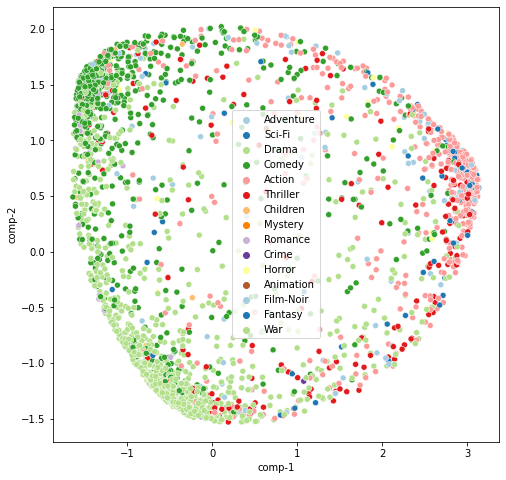

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.94067574>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9308761>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.94802743>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9592>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9527531>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9694125>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9553064>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9515399>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.945025>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9461338>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9367889>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9473165>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9585402>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.95805734>}
{'batch_loss': <tf.Te

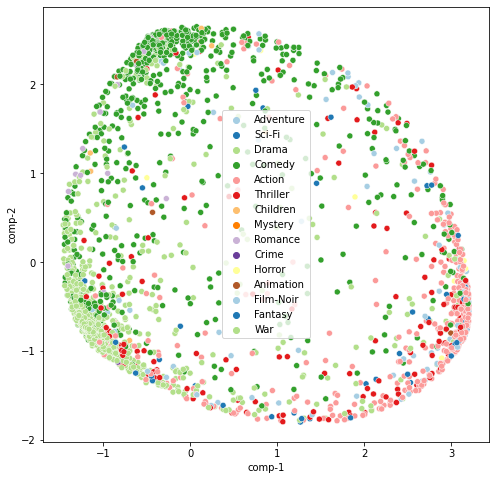

CPU times: user 1min 23s, sys: 1.52 s, total: 1min 24s
Wall time: 1min 34s


In [63]:
%%time
# Train new model
epochs= 3
test_set = train[(train[userCol]>0)&(train[userCol]<5000)]
model_plot(model, movies, test_set, is_full_ft= True )
for n in range(epochs):
  print(n, "/", epochs, ": ", model._spv_constrastive_train_minibatch_step_fullft(train_warm.sample(frac=.5), batch_size=512))
  model_plot(model, movies, test_set, is_full_ft= True )
  gc.collect()

# Pick item pipeline

In [64]:
test_warm_up, test_mask = train_test_split(test, test_size= 0.5)

In [65]:
test_items = test.groupby(itemCol).count().sort_values(by=userCol, ascending=False).head(1000).index

In [66]:
%%time 
# Item catalog of shortlist based in mesuable item in test (for evaluation process)
model.get_shortlist( 
    ratings = train[ train[userCol].isin(train_warm.index) & train[itemCol].isin( test_items )],
    interaction_list = train_warm,
    limit = 50, 
    cluster_num = 5
)

Get cluster duration:  5.929877758026123
Join interaction duration:  1.031590223312378


100%|██████████| 25/25 [00:20<00:00,  1.22it/s]
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.9s finished


Chunk explode duration:  23.29566478729248
Chunk explode duration:  0.012814521789550781
Total duration:  30.274289846420288
CPU times: user 12.7 s, sys: 979 ms, total: 13.7 s
Wall time: 30.7 s


In [67]:
gc.collect()

1232

In [68]:
model.shortlist

,clusters,movieId,contribute_score,rank
27,0,50,0.748354,10.0
39,0,111,0.701242,46.0
99,0,296,0.754827,6.0
107,0,318,0.778459,2.0
166,0,527,0.756872,4.0
...,...,...,...,...
36560,42,58559,0.774628,2.0
36561,42,59315,0.671401,49.0
36562,42,60069,0.676467,42.0
36567,42,68358,0.683102,36.0


In [69]:
%%time 
top_k = 50

y_pred = model.batch_get_recommend(
        historical_ratings= test_warm_up, 
        top_k = top_k, is_remove_interacted = True, 
        batch_size= 1024*10,
        reduce_method="mean", 
        cluster_num= 5, 
        using_rapids= False
    )

historical_ratings shape  (3487378, 5)
Get cluster for user duration:  25.941869497299194
wu shape  (242365, 3)
user_num  48473
Prepare to join duration:  0.49378228187561035


0it [00:00, ?it/s]

wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape:  (898000, 6)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape:  (897500, 6)
after reduce wu shape: after reduce wu shape:  (266602, 3)
reduce duration:  77.08618831634521
 (266103, 3)
reduce duration:  77.24959659576416


5it [01:29, 17.82s/it]

after remove interacted wu shape: after remove interacted wu shape:  (243896, 3)
remove interacted item duration:  11.885223627090454
 (243113, 3)
remove interacted item duration:  11.723360776901245
all chunk processing time duration: all chunk processing time duration:  89.07488059997559
 89.07360601425171
wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape:  wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape:  (898750, 6)


(883500, 6)
after reduce wu shape:  (267648, 3)
reduce duration:  75.97209024429321
after reduce wu shape:  after remove interacted wu shape:  (244871, 3)
(261518, 3)
reduce duration:  83.81065630912781
remove interacted item duration:  7.986430883407593
all chunk processing time duration:  88.642009973526
after remove interacted wu shape:  (238869, 3)
remove interacted item duration:  5.699965715408325
wu = chunk.merge(shortlist, on="clusters", how='inner') : wu shape:  (909250, 6)
all chunk processing time duration:  91.08927798271179
after reduce wu shape:  (269506, 3)
reduce duration:  37.745139360427856
after remove interacted wu shape:  (246624, 3)
remove interacted item duration:  5.7618067264556885
all chunk processing time duration:  43.580241203308105


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


Join duration:  222.69747757911682
Total duration:  249.1515555381775
CPU times: user 4min 20s, sys: 18.1 s, total: 4min 38s
Wall time: 4min 9s


In [70]:
gc.collect()

50

In [71]:
y_pred

,userId,movieId,matched_score,rank
0,3,29,0.680887,38.0
2,3,50,0.735280,7.0
3,3,110,0.677473,43.0
5,3,293,0.682837,32.0
6,3,296,0.718139,11.0
...,...,...,...,...
269500,51199,6016,0.706396,14.0
269501,51199,7153,0.688699,27.0
269502,51199,7361,0.688033,30.0
269503,51199,44555,0.703734,16.0


In [72]:
y_pred.shape[0]/y_pred[userCol].drop_duplicates().shape[0]

49.66012926231335

In [73]:
y_true = test
y_true["is_fav"] = y_true["rating"].apply(lambda x: 1 if x>2.5 else 0)

In [74]:
y_true

,userId,movieId,rating,timestamp,y,is_fav
236,3,1,4.0,944919407,0.6,1
237,3,24,3.0,945176048,0.2,1
238,3,32,4.0,944918047,0.6,1
239,3,50,5.0,944918018,1.0,1
240,3,160,3.0,945176048,0.2,1
...,...,...,...,...,...,...
19999630,138489,2959,4.5,1352990114,0.8,1
19999631,138489,3671,4.0,1352989107,0.6,1
19999632,138489,4973,4.0,1352990124,0.6,1
19999633,138489,5291,4.5,1352990158,0.8,1


In [75]:
def evaluate_model(y_true, y_pred):
    """
    y_true: dataframe: user_id, item_id, is_fav (1 true, 0 false)
    y_pred: dataframe: user_id, item_id
    return:
    precision@k, recall@k
    """
    y_pred2 = y_pred.copy()
    y_pred2["is_rec"] = 1
    y_true2 = y_true.copy()

    total1 = y_true2.merge(y_pred2, on=[userCol, itemCol], how = 'left')
    total1["rec_fav"] = total1["is_rec"].fillna(0) * total1["is_fav"]

    # Precision
    p = total1["rec_fav"].sum() / total1["is_rec"].sum()

    # Recall
    r = total1["rec_fav"].sum() / total1["is_fav"].sum()

    print("Rec matched: ", total1["is_rec"].sum())
    print("All labels: ", total1["is_fav"].sum())

    return p, r

In [76]:
precision, recall = evaluate_model(y_true, y_pred)

Rec matched:  97954.0
All labels:  5749935


In [77]:
print("Precision :", precision)

Precision : 0.9536415051963166


In [78]:
recall

0.016245922779996643

# END HERE